# Importando as bibliotecas

In [1]:
import pandas as pd
import tensorflow
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import datetime
import random

# fonte do banco de dados:
# https://datahack.analyticsvidhya.com/contest/mckinsey-analytics-online-hackathon/#ProblemStatement


# for jupyter
%matplotlib inline

2022-08-08 07:30:35.268374: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-08 07:30:35.268402: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# importar os dados
dt = pd.read_csv('train.csv')
dt.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


# Plotando os dados

In [3]:
def strokes(x,v = 1):
    """ função para filtrar a base de dados e retornar apenas pacientes que sofreram ou não AVC """
    r = x[x['stroke'] == v ]
    return r

def change_text(text):
    """
        Melhorar a exibição dos valores das abcissas
    """
    if isinstance(text,str):
        # tratar textos longos, permitir a quebra da linha
        return text.replace(' ','\n').replace('_','\n').replace('-','\n')
    elif (isinstance(text,int)) or  (isinstance(text,(int, np.integer))): 
        # traduzir valores binários
        return "Yes" if text == 1 else "No"
    elif text == None:
        return "Null"
    else:
        return text

 
    
def distribuicao(x,col=None):
    """
        Cria um gráfico de distribuição em função da coluna e avc, isto é,
        cada valor diferente da coluna será gerada duas barras, uma com pacientes com avc uma sem
    """
    
    # tamanho da figura a ser exibida
    plt.rcParams["figure.figsize"] = (10,5)
    
    # espaçamento entre cada valor
    x_space = 3;
    
    xs = [None]
    if col != None:
        # valores possíveis do conjunto domínio
        xs = x[col].unique()
    
    # porcentagem da distribuição de cada domínio com AVC
    percents = []
    
    # labels a serem adicionados na legenda
    labels = ["no stroke","suffered stroke"]
    
    # vamos percorrer cada domínio
    for i,vx in enumerate(xs):
        classe = x;
        
        if vx != None:
            # filtrar o dataset apenas com a coluna desejada
            classe = x[ x[col] == vx ]

            # tratar a coluna com registros nulos
            if str(vx)== "nan":
                classe = x[ dt[col].apply(lambda a: True if str(a) == "nan" else False)  ]

        # pegar a quantidade de elementos com stroke = 1 e = 0, respectivamente, em função do domínio
        p, n = len(strokes(classe,1)), len(strokes(classe,0))

        # criar as barras no gráfico
        plt.bar([(i*x_space)],[n], color='g', label=labels[0])
        plt.bar([(i*x_space)+1],[p], color='r', label=labels[1])
        
        # garantir que a próxima legenda de outro domínio não seja inserida
        labels = None, None
        
        # calcular a porcentagem de cada domínio
        percent = 0
        if p+n > 0:
            percent = round((p/(p+n))*100,2)
        #armazenar numa lista, já com os locais para desenhar
        percents.append( [ percent, p, (i*x_space)+1, max(p,n)] )
    
    #adicionar título ao gráfico
    plt.title(col+" distribution" if col!=None else "Distribution",fontsize=20)
    
    # adicionar os labels do eixo das abscissas
    if (xs[0] != None) and (len(xs) > 1):
        plt.xticks(ticks=[ (i*x_space)+0.5 for i,x in enumerate(xs)], labels=[change_text(i) for i in xs],fontsize=20)
    
    # adicioanr as porcentagens das distribuições com avc
    for v in percents:
        plt.text(v[2], v[1]+ max(percents,key=lambda b: b[3])[3]*0.02, str(v[0])+"%", fontsize=11, horizontalalignment='center')
    
    
    # mostrar a legenda
    plt.legend(loc="best")
    # mostrar o gráfico
    plt.show( )

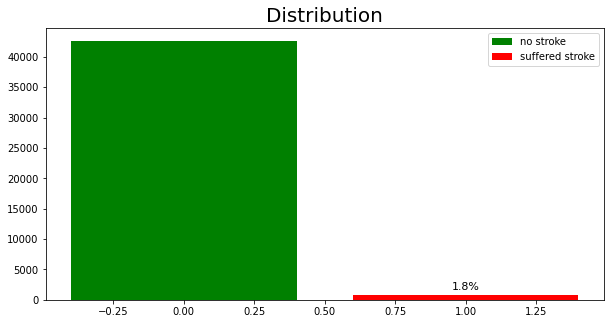

In [4]:
#distribuição da classe que vamos prever
distribuicao(dt)

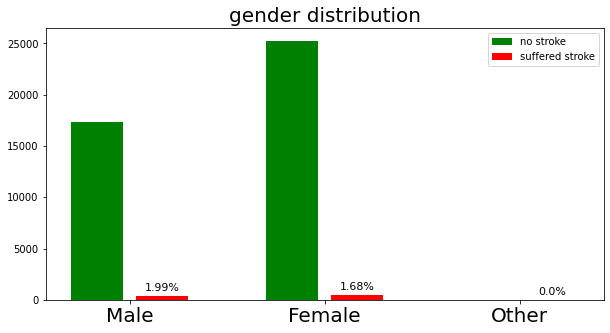

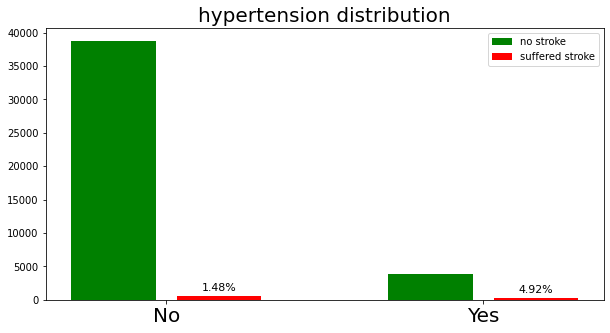

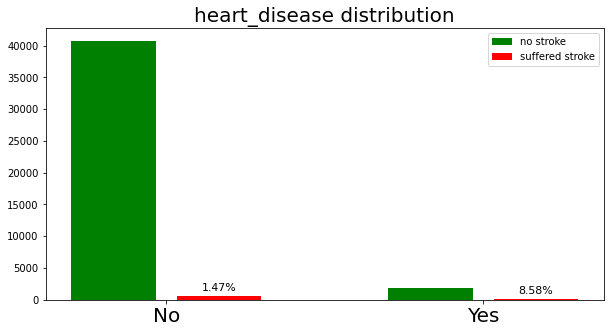

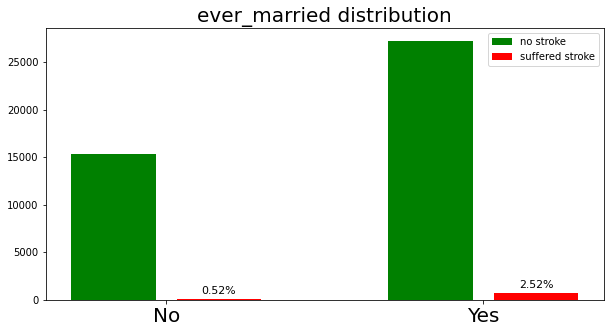

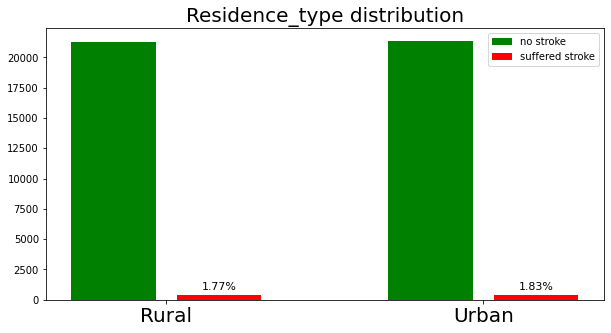

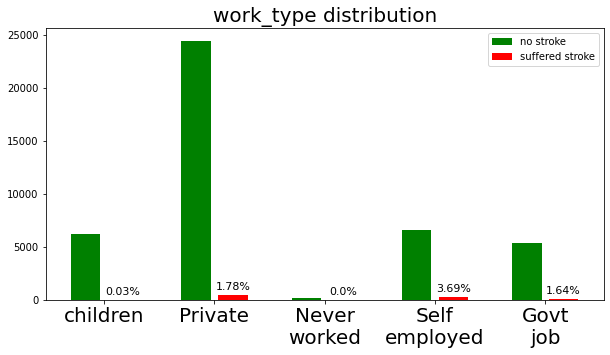

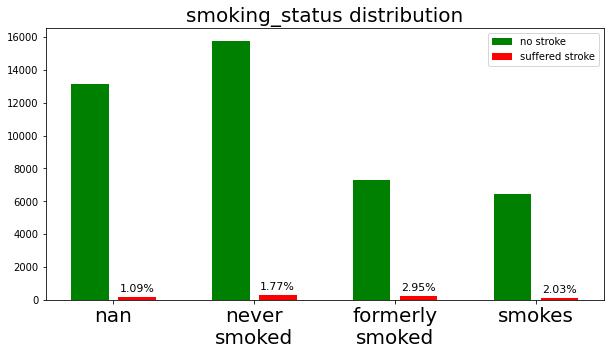

In [5]:
# mostrar a distribuição de cada coluna
l = ["gender","hypertension","heart_disease","ever_married","Residence_type","work_type","smoking_status"]
for i in l:
    distribuicao(dt,str(i))

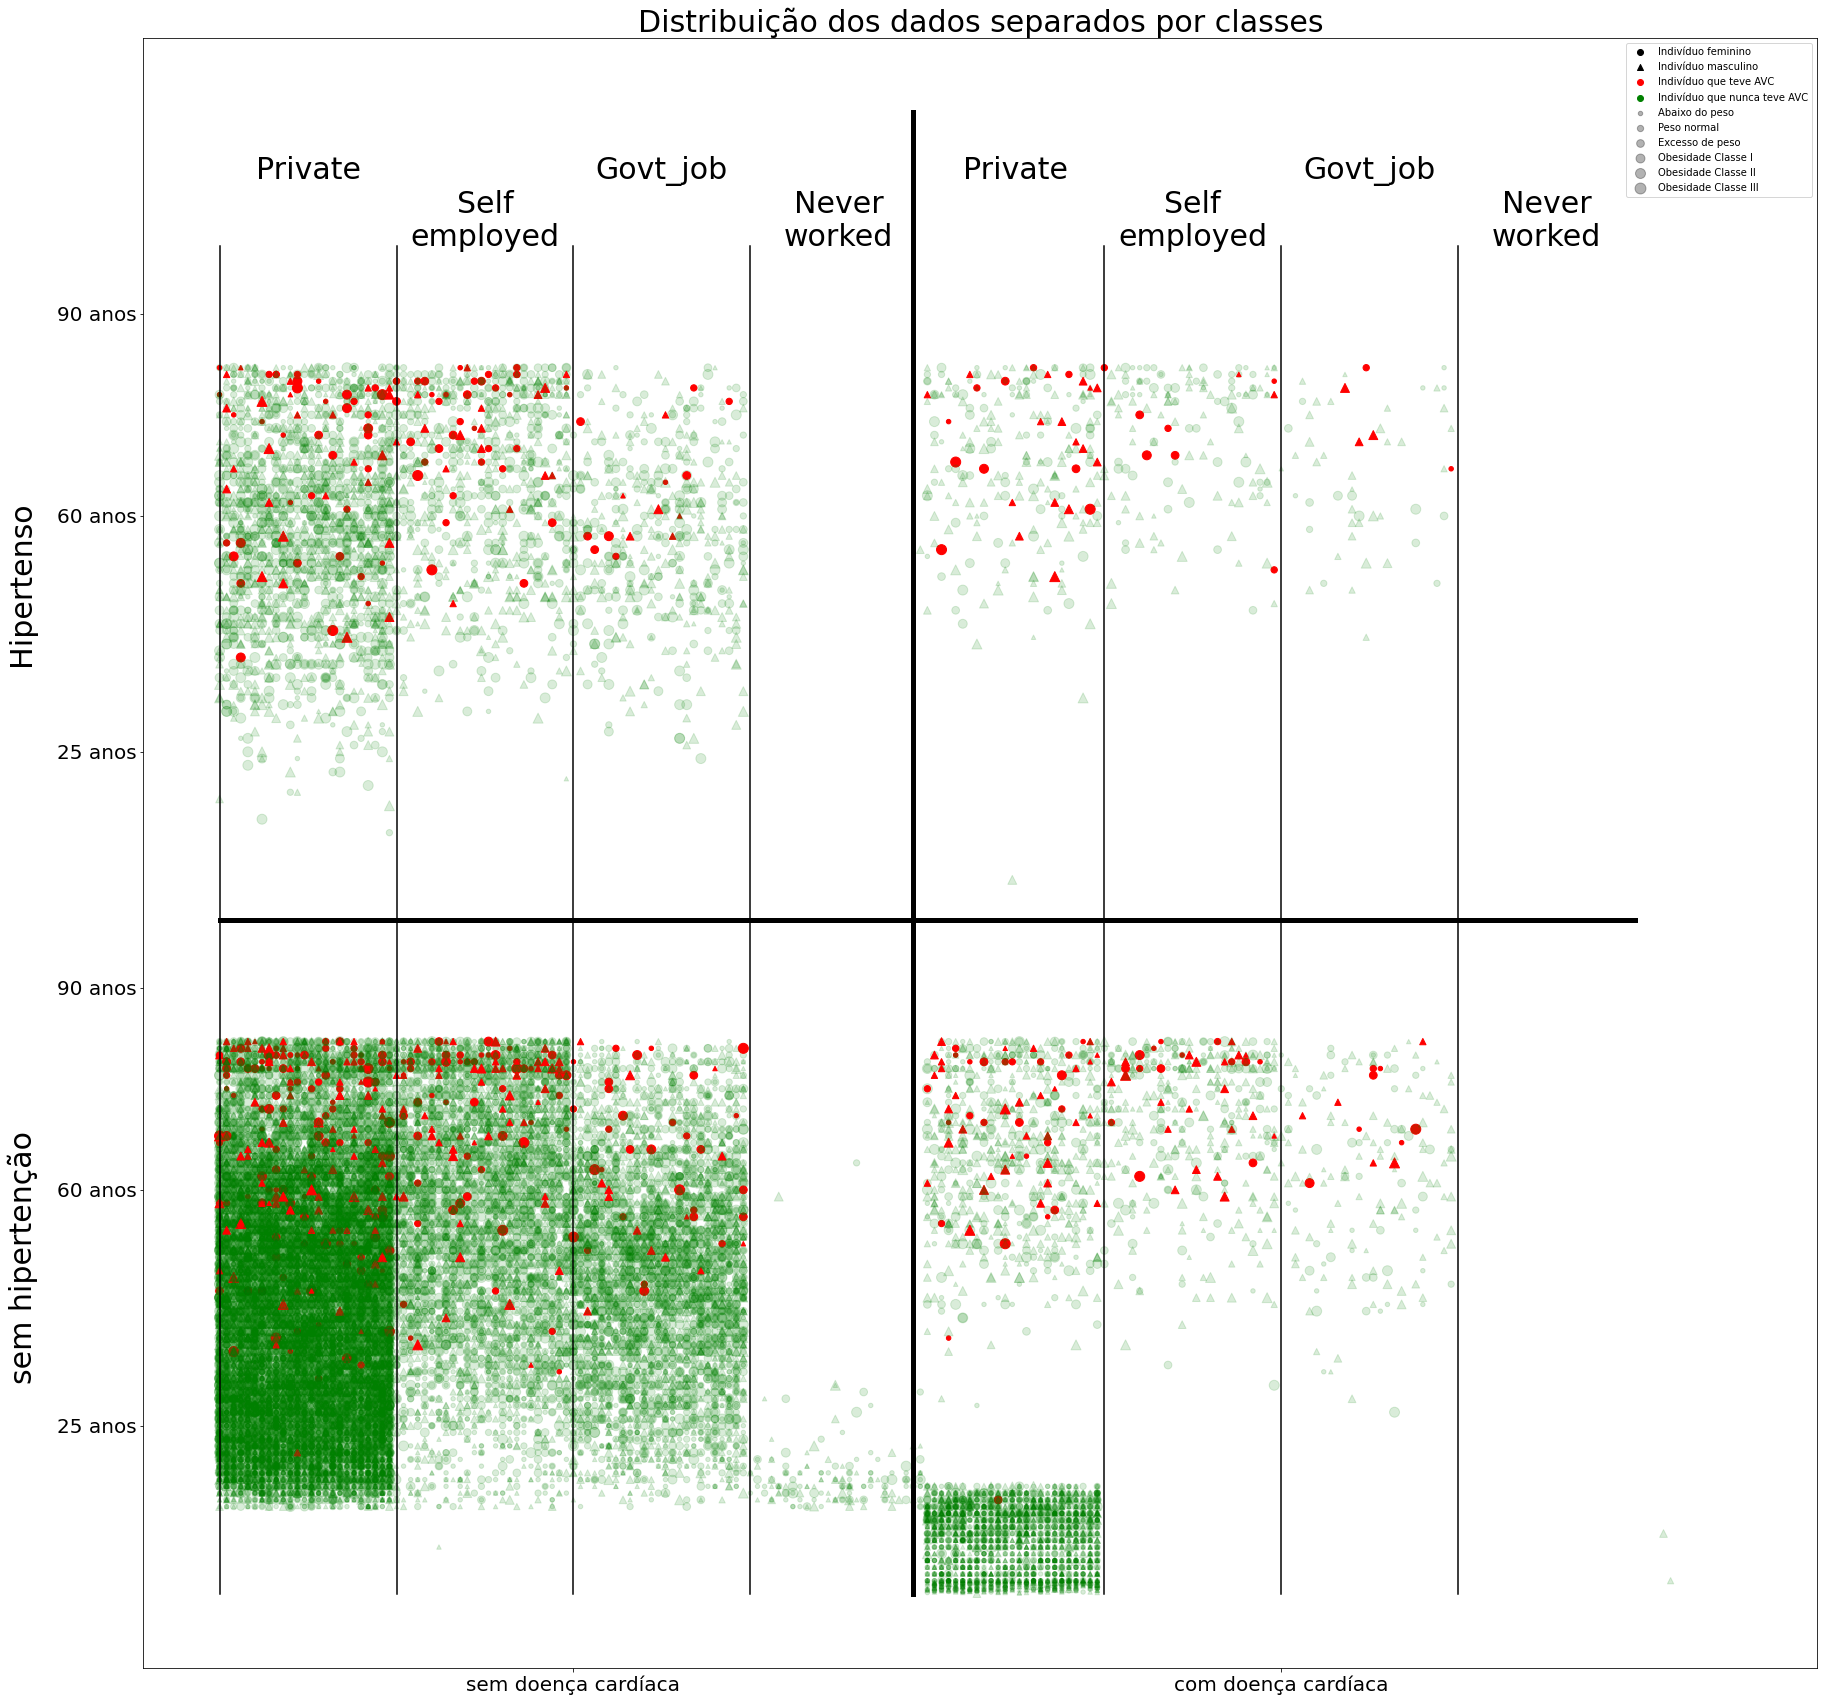

In [6]:
# muda o tamanho da figura do gráfico
plt.rcParams["figure.figsize"] = (30,30)

# cria uma lista com os tipos de trabalo
lista = ['Private', 'Self-employed', 'Govt_job', 'Never_worked',"children"]

#p = strokes(dt,1)
#n = strokes(dt,0)

data_print = dt.copy();
data_print['work'] = data_print['work_type'].apply(lambda x: lista.index(x))

data_print['cor'] = data_print['stroke'].apply(lambda x:'r' if x == 1 else 'g')
data_print['alpha'] = data_print['stroke'].apply(lambda x:0.15 if x == 0 else 1)
data_print['size'] = data_print['bmi'].apply(lambda  x: round(x*10) if str(x) != "nan" else 0 )
data_print['hyper_age'] = (data_print['hypertension'])+(data_print['age']/100)
data_print['heart_work'] = data_print['heart_disease']+(
    data_print['work'].apply(lambda x: (x/4) + (random.randrange(0,25)/100) )
)

def set_imc_class(value):
    lista_obsidade = [18.5, 25, 30,35,40, 9999]
    for i,v in enumerate(lista_obsidade):
        if value < v:
            return i*20

data_print['imc_class'] = data_print["bmi"].apply(set_imc_class )


data_F = data_print[data_print['gender'] == 'Female'].copy()
data_M = data_print[data_print['gender'] == 'Male'].copy()

plt.scatter(y=data_F['hyper_age'], 
            x=data_F['heart_work'], 
            c=data_F['cor'], 
            alpha=data_F['alpha'], 
            marker='o', 
            #s=data_F['size'],
            s=data_F['imc_class'],
   
           )
plt.scatter(y=data_M['hyper_age'], 
            x=data_M['heart_work'], 
            c=data_M['cor'], 
            alpha=data_M['alpha'], 
            marker='^', 
            #s=data_M['size'],
            s=data_M['imc_class'],
    
           )
 
    
plt.xticks(ticks=[0.5,1.5], labels=["sem doença cardíaca","com doença cardíaca"],fontsize=20)
plt.yticks(ticks=[0.25,0.6,0.9, 1.25, 1.6,1.9], 
           labels=["25 anos", "60 anos","90 anos",
                  "25 anos", "60 anos","90 anos"],
           
           fontsize=20)

plt.text(-0.3, 0.5, "sem hipertenção", fontsize=30,  rotation='vertical',  verticalalignment='center')
plt.text(-0.3, 1.5, "Hipertenso", fontsize=30,  rotation='vertical',  verticalalignment='center')

plt.plot( [0.98,0.98] , [0,2.2], linestyle='solid', c="black", linewidth=5)  
plt.plot( [0,2] , [1,1], linestyle='solid', c="black", linewidth=5)  


plt.plot( [0.00,0.00] , [0.0,2.], linestyle='solid', c="black")
plt.plot( [0.25,0.25] , [0.0,2.], linestyle='solid', c="black")  
plt.plot( [0.50,0.50] , [0.0,2.], linestyle='solid', c="black")  
plt.plot( [0.75,0.75] , [0.0,2.], linestyle='solid', c="black")  


plt.plot( [0.98,0.98] , [0.0,2.], linestyle='solid', c="black")
plt.plot( [1.25,1.25] , [0.0,2.], linestyle='solid', c="black")  
plt.plot( [1.50,1.50] , [0.0,2.], linestyle='solid', c="black")  
plt.plot( [1.75,1.75] , [0.0,2.], linestyle='solid', c="black")  


plt.text(   0+0.125, 2.1, "Private", fontsize=30,  horizontalalignment='center')
plt.text(0.25+0.125, 2.0, "Self\nemployed", fontsize=30,  horizontalalignment='center')
plt.text(0.50+0.125, 2.1, "Govt_job", fontsize=30,  horizontalalignment='center')
plt.text(0.75+0.125, 2.0, "Never\nworked", fontsize=30,  horizontalalignment='center')


plt.text(   0+1.125, 2.1, "Private", fontsize=30,  horizontalalignment='center')
plt.text(0.25+1.125, 2.0, "Self\nemployed", fontsize=30,  horizontalalignment='center')
plt.text(0.50+1.125, 2.1, "Govt_job", fontsize=30,  horizontalalignment='center')
plt.text(0.75+1.125, 2.0, "Never\nworked", fontsize=30,  horizontalalignment='center')



# legenda
plt.scatter(x=None,y=None, c='k', marker='o', label="Indivíduo feminino")
plt.scatter(x=None,y=None, c='k', marker='^', label="Indivíduo masculino")
plt.scatter(x=None,y=None, c='r',  label="Indivíduo que teve AVC")
plt.scatter(x=None,y=None, c='g',  label="Indivíduo que nunca teve AVC")
plt.scatter(x=None,y=None, c='k', alpha=0.3, s=1*20, label="Abaixo do peso")
plt.scatter(x=None,y=None, c='k', alpha=0.3, s=2*20, label="Peso normal")
plt.scatter(x=None,y=None, c='k', alpha=0.3, s=3*20, label="Excesso de peso")
plt.scatter(x=None,y=None, c='k', alpha=0.3, s=4*20, label="Obesidade Classe I")
plt.scatter(x=None,y=None, c='k', alpha=0.3, s=5*20, label="Obesidade Classe II")
plt.scatter(x=None,y=None, c='k', alpha=0.3, s=6*20, label="Obesidade Classe III")



plt.legend(loc='best')
plt.title("Distribuição dos dados separados por classes",fontsize=30)


plt.show()
#plt.scatter(y=tp[i]['age'],x=tp[i]['heart_disease'].apply(lambda x:  x+(random.randrange(0,aumento)/100)), c='r', alpha=0.8,  marker=markers[i], s=tp[i]['bmi'].apply(lambda x: round(x*10) if str(x) != "nan" else 0 ) )


# Normalizando os Dados

In [18]:
def Normaliza_dados(dados):
    """
        Funcão responsável por normalizar os dados, tratar valores nulos e separar colunas 
    """
    #d = dados[dados['gender'] != 'Other'].copy()
    d = dados.copy()
    
    # precisavamos transformar os dados de texto em número
    # listas para atribuir indices em cada elemento da coluna
    sim_nao = ['yes','no']
    residencia = ['Urban', 'Rural']
    smokes = ['formerly_smoked', 'never_smoked', 'smokes' ]
    works = ['Private', 'Self-employed', 'Govt_job', 'Never_worked']
    
    # normalizar o gênero
    def set_gender(x):
        sexo = ['Male', 'Female','Other']
        r = sexo.index(x)
        if r == 2:
            r = 0.5
        return r
    
    # aplicar a normalização em cada coluna
    d['gender'] = d['gender'].apply(set_gender)
    d['ever_married'] = d['ever_married'].apply( lambda x: sim_nao.index(x.lower()))
    d['Residence_type'] = d['Residence_type'].apply( lambda x: residencia.index(x))

    # nessa coluna vamos fazer diferente, criamos uma coluna binária para cada tipo de trabalho
    for i in works:
        d['work_type_'+i] = dt['work_type'].apply(lambda x: 1 if x == i else 0)
    #for i in smokes:
    #    d['smokes_'+i] = dt['smoking_status'].apply(lambda x: 1 if x == i else 0)
        
    # removemos a coluna com tipo texto
    d.drop('work_type',axis=1, inplace=True)
    d.drop('smoking_status',axis=1,inplace=True)
    
    # normalizar idade, glicose
    d['age'] = d['age'].apply(lambda x: x/100)
    d['avg_glucose_level'] = d['avg_glucose_level'].apply(lambda x: (x-55)/(300 - 55) )

    #atribui a média de IMC nos dados que faltam
    media_imc = d['bmi'].mean()
    d['bmi'] = d['bmi'].apply(lambda x: media_imc if (str(x) == 'nan') else x)
    # normaliza o imc
    d['bmi'] = d['bmi']/100
    # retorna o dataset normalizado
    return d


d = Normaliza_dados(dt)
d

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Private,work_type_Self-employed,work_type_Govt_job,work_type_Never_worked
0,30669,0.0,0.03,0,0,1,1,0.163755,0.180,0,0,0,0,0
1,30468,0.0,0.58,1,0,0,0,0.134531,0.392,0,1,0,0,0
2,16523,1.0,0.08,0,0,1,0,0.228122,0.176,0,1,0,0,0
3,56543,1.0,0.70,0,0,0,1,0.057306,0.359,0,1,0,0,0
4,46136,0.0,0.14,0,0,1,1,0.433796,0.191,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43395,56196,1.0,0.10,0,0,1,0,0.014857,0.204,0,0,0,0,0
43396,5450,1.0,0.56,0,0,0,0,0.647388,0.554,0,0,0,1,0
43397,28375,1.0,0.82,1,0,0,0,0.150776,0.289,0,1,0,0,0
43398,27973,0.0,0.40,0,0,0,0,0.180245,0.332,0,1,0,0,0


In [18]:
"""plt.rcParams["figure.figsize"] = (30,30)

lista = ['Private', 'Self-employed', 'Govt_job', 'Never_worked',"children"]
    
dt['work'] = dt['work_type'].apply(lambda x: lista.index(x))

p = strokes(dt,1)
n = strokes(dt,0)

tp = [p[p['work'] == i] for i in range(4)]
tn = [n[n['work'] == i] for i in range(4)]

#lista = ['Private', 'Self-employed', 'Govt_job']
markers = ['s','^','x',"o"]
import random
aumento = 90

media_bmi = round(dt['bmi'].mean()*1.3)
for i in range(4):
    plt.scatter(y=tn[i]['age'],x=tn[i]['heart_disease'].apply(lambda x:  x+(random.randrange(0,aumento)/100)), c='g', alpha=0.15, marker=markers[i], s=tn[i]['bmi'].apply(lambda  x: round(x*1.3) if str(x) != "nan" else media_bmi), label="a"+str(i)  )
    plt.scatter(y=tp[i]['age'],x=tp[i]['heart_disease'].apply(lambda x:  x+(random.randrange(0,aumento)/100)), c='r', alpha=0.8,  marker=markers[i], s=tp[i]['bmi'].apply(lambda x: round(x*1.3) if str(x) != "nan" else media_bmi ), label="a"+str(i) )

plt.legend(loc="best")
#"smoking_status"]
"""

'plt.rcParams["figure.figsize"] = (30,30)\n\nlista = [\'Private\', \'Self-employed\', \'Govt_job\', \'Never_worked\',"children"]\n    \ndt[\'work\'] = dt[\'work_type\'].apply(lambda x: lista.index(x))\n\np = strokes(dt,1)\nn = strokes(dt,0)\n\ntp = [p[p[\'work\'] == i] for i in range(4)]\ntn = [n[n[\'work\'] == i] for i in range(4)]\n\n#lista = [\'Private\', \'Self-employed\', \'Govt_job\']\nmarkers = [\'s\',\'^\',\'x\',"o"]\nimport random\naumento = 90\n\nmedia_bmi = round(dt[\'bmi\'].mean()*1.3)\nfor i in range(4):\n    plt.scatter(y=tn[i][\'age\'],x=tn[i][\'heart_disease\'].apply(lambda x:  x+(random.randrange(0,aumento)/100)), c=\'g\', alpha=0.15, marker=markers[i], s=tn[i][\'bmi\'].apply(lambda  x: round(x*1.3) if str(x) != "nan" else media_bmi), label="a"+str(i)  )\n    plt.scatter(y=tp[i][\'age\'],x=tp[i][\'heart_disease\'].apply(lambda x:  x+(random.randrange(0,aumento)/100)), c=\'r\', alpha=0.8,  marker=markers[i], s=tp[i][\'bmi\'].apply(lambda x: round(x*1.3) if str(x) != "na

In [11]:


dr = d['stroke']
d =d.drop('stroke',axis=1)
d =d.drop('id',axis=1)


x_tmp,x_valida,y_tmp,y_valida = train_test_split(d, dr,test_size= 0.1, random_state=0)
#x_treino,x_teste,y_treino,y_teste = train_test_split(x_tmp, y_tmp,test_size= 0.7, random_state=0)


from imblearn.over_sampling import RandomOverSampler
#oversample = RandomOverSampler(sampling_strategy='minority')
oversample = RandomOverSampler(sampling_strategy=0.5)
X_over, y_over = oversample.fit_resample(x_tmp, y_tmp)




from sklearn.model_selection import train_test_split
x_treino,x_teste,y_treino,y_teste = train_test_split(X_over,y_over,test_size=0.3,stratify=y_over,random_state=42)






In [37]:


optimizer_adam = tf.keras.optimizers.Adam(learning_rate=0.0022)

# alguns otimizadores que utlizamos no fine-tuning
optimizer_SGD = tf.keras.optimizers.SGD(
    learning_rate=0.02975,
    momentum=0.05,
    nesterov=False,
    name='SGD')

optimizer_Adagrad = tf.keras.optimizers.Adagrad(
    learning_rate=0.001,
    initial_accumulator_value=0.01,
    epsilon=1e-02,
    name="Adagrad",

)


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, 
    histogram_freq=1,
    #write_images=True,
    write_steps_per_second=True,
    write_graph=True,
                                                     )

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(30,activation=tf.nn.relu,input_shape=(x_treino.shape[1],)))
model.add(tf.keras.layers.Dense(40,activation=tf.nn.relu ))
model.add(tf.keras.layers.Dense(20,activation=tf.nn.sigmoid ))
model.add(tf.keras.layers.Dense(1,activation=tf.nn.sigmoid ))
model.summary()
model.compile(optimizer=optimizer_adam,
              loss='MeanSquaredError',
              metrics=['accuracy','Recall'])

tf.summary.trace_on(graph=True, profiler=False)

model.fit(x_treino,y_treino,batch_size=60, epochs=50,verbose=2,  validation_split=0.9,
          callbacks=[tensorboard_callback]
          )

teste  = model.evaluate(x_teste,  y_teste, verbose=2)
treino = model.evaluate(x_treino,  y_treino, verbose=2)

model.save('save/model2/'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 30)                390       
                                                                 
 dense_21 (Dense)            (None, 40)                1240      
                                                                 
 dense_22 (Dense)            (None, 20)                820       
                                                                 
 dense_23 (Dense)            (None, 1)                 21        
                                                                 
Total params: 2,471
Trainable params: 2,471
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
68/68 - 6s - loss: 0.2083 - accuracy: 0.6791 - recall: 0.1235 - val_loss: 0.1781 - val_accuracy: 0.7160 - val_recall: 0.5488 - 6s/epoch - 85ms/step
Epoch 2/50
68/68 - 2s - l

68/68 - 1s - loss: 0.1379 - accuracy: 0.7988 - recall: 0.7409 - val_loss: 0.1458 - val_accuracy: 0.7835 - val_recall: 0.7289 - 1s/epoch - 18ms/step
Epoch 47/50
68/68 - 1s - loss: 0.1375 - accuracy: 0.8008 - recall: 0.7416 - val_loss: 0.1464 - val_accuracy: 0.7827 - val_recall: 0.7477 - 1s/epoch - 18ms/step
Epoch 48/50
68/68 - 1s - loss: 0.1371 - accuracy: 0.7998 - recall: 0.7480 - val_loss: 0.1472 - val_accuracy: 0.7795 - val_recall: 0.6288 - 1s/epoch - 17ms/step
Epoch 49/50
68/68 - 1s - loss: 0.1381 - accuracy: 0.7968 - recall: 0.7445 - val_loss: 0.1456 - val_accuracy: 0.7886 - val_recall: 0.7378 - 1s/epoch - 17ms/step
Epoch 50/50
68/68 - 1s - loss: 0.1360 - accuracy: 0.8008 - recall: 0.7445 - val_loss: 0.1474 - val_accuracy: 0.7802 - val_recall: 0.7703 - 1s/epoch - 15ms/step
540/540 - 1s - loss: 0.1439 - accuracy: 0.7847 - recall: 0.7712 - 738ms/epoch - 1ms/step
1259/1259 - 2s - loss: 0.1462 - accuracy: 0.7825 - recall: 0.7737 - 2s/epoch - 1ms/step
INFO:tensorflow:Assets written to: 

In [38]:
print(model.evaluate(x_valida,  y_valida, verbose=2))

136/136 - 0s - loss: 0.1316 - accuracy: 0.7765 - recall: 0.7429 - 297ms/epoch - 2ms/step
[0.1315983533859253, 0.7764977216720581, 0.7428571581840515]


In [22]:
#salva o modelo e os pesos
model.save('logs/model.h5')

In [80]:
#    --> Faz a conversão do modelo para o arqiovo json
#    tensorflowjs_converter --input_format=keras logs/model.h5 server/public/model

In [40]:
"""
    Vamos enviar o conjunto de teste para realizar a predição
"""
t = pd.read_csv("test.csv")
t.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,36306,Male,80.0,0,0,Yes,Private,Urban,83.84,21.1,formerly smoked
1,61829,Female,74.0,0,1,Yes,Self-employed,Rural,179.50,26.0,formerly smoked
2,14152,Female,14.0,0,0,No,children,Rural,95.16,21.2,NaN
3,12997,Male,28.0,0,0,No,Private,Urban,94.76,23.4,NaN
4,40801,Female,63.0,0,0,Yes,Govt_job,Rural,83.57,27.6,never smoked


In [41]:
# normaliza os dados do dataset
tt = Normaliza_dados(t)
# exlcui a coluna id
tt = tt.drop('id',axis=1)
tt

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,work_type_Private,work_type_Self-employed,work_type_Govt_job,work_type_Never_worked
0,0.0,0.80,0,0,0,0,0.117714,0.211,0,0,0,0
1,1.0,0.74,0,1,0,1,0.508163,0.260,1,0,0,0
2,1.0,0.14,0,0,1,1,0.163918,0.212,1,0,0,0
3,0.0,0.28,0,0,1,0,0.162286,0.234,1,0,0,0
4,1.0,0.63,0,0,0,1,0.116612,0.276,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
18596,0.0,0.20,0,0,1,1,0.079306,0.184,1,0,0,0
18597,0.0,0.61,0,0,0,1,0.638980,0.316,1,0,0,0
18598,1.0,0.79,0,0,0,1,0.288735,0.294,1,0,0,0
18599,0.0,0.55,0,0,0,1,0.059020,0.338,0,0,1,0


In [42]:
# faz as predições dos dados de tt
valores = model.predict(tt)
valores

582/582 [==============================] - 1s 2ms/step


array([[0.67415446],
       [0.85123086],
       [0.02161304],
       ...,
       [0.7639496 ],
       [0.4433243 ],
       [0.03840561]], dtype=float32)

In [43]:
#salva os valores no formato específico para enviar e validar os dados
val = [ 1 if x > 0.5 else 0 for x in valores]
print(sum(val)/len(val))
print("len:",len(val))

#df = 
df = t.copy()
df['stroke'] = val
df.drop(["gender","age","hypertension","heart_disease","ever_married","work_type","Residence_type","avg_glucose_level","bmi","smoking_status"],axis=1,inplace=True)
df.reset_index(drop=True, inplace=True)
df['id'].set_index=True


df.to_csv("final.csv",index=False)
df

0.2526745873877749
len: 18601


,id,stroke
0,36306,1
1,61829,1
2,14152,0
3,12997,0
4,40801,0
...,...,...
18596,67353,0
18597,362,1
18598,29839,1
18599,6438,0
